## CS-E4820 Machine Learning: Advanced Probabilistic Methods (spring 2022)

Pekka Marttinen, Prayag Tiwari, Vishnu Raj, Tianyu Cui, Yogesh Kumar, Antti Pöllänen, Louis Filstroff, Alex Aushev, Zheyang Shen, Nikitin Alexander , Sebastiaan De Peuter.

## Exercise 4, due on Tuesday February 15th at 23:50.


### Contents
1. Problem 1: ML-II for linear model
2. Problem 2: Optimizing hyperparameters with validation set
3. Problem 3: Poisson regression with Laplace approximation


# Problem 1: ML-II for a linear model

Fit the Bayesian linear parameter model to a given data 'ex4_1_data.txt' using the ML II approach. Optimize the hyperparameters $\alpha$ and $\beta$ using grid search. Complete the template given below with your own code. Make predictions for the test data using the fitted model and compute the mean squared error for test data. Also plot the data and the fitted model.

In [1]:
# Starter code for problems 1 and 2. 
# NOTE: variables defined in this cell are used in code templates for problem 1 and 2.
import numpy as np
import matplotlib.pyplot as plt

# INITIALIZATION
# Load the observations
data = np.loadtxt('/coursedata/ex4_1_data.txt')
x_obs = data[:,0]
y_obs = data[:,1]

# Training data
N_train = 40
x_train = x_obs[:N_train]
y_train = y_obs[:N_train]

# Validation data
N_valid = 10
x_valid = x_obs[N_train:N_train+N_valid]
y_valid = y_obs[N_train:N_train+N_valid]

# Testing data
N_test = 10
x_test = x_obs[N_train+N_valid:]
y_test = y_obs[N_train+N_valid:]


x_range = (-5, 5) # Possible values of x are in this range

# Basis function parameters
num_basis_functions = 11
centers = np.linspace(x_range[0], x_range[1], num_basis_functions)
lambdaval = 0.17
# You can use here assume the correct basis function centers and lambda ...
def rbf(x, centers, lambdaval):
    # Radial Basis Function output for input x
    #
    # Inputs:
    # x : input points (one-dimensional array)
    # centers : basis function centers (one-dimensional array)
    # lambdaval : basis function width (scalar)
    #
    # Output:
    # Radial Basis Functions evaluated at x (two-dimensional array with len(x)
    #                                        rows and len(centers) columns)
    d = x[:,np.newaxis] - centers[np.newaxis,:]
    y = np.exp(-0.5 * (d ** 2) / lambdaval)
    return y

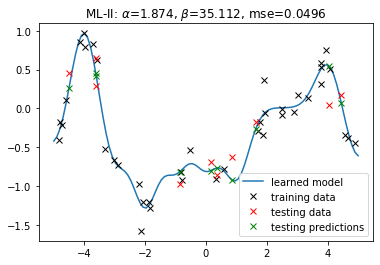

In [2]:
    # Template for problem 1
    from numpy.linalg import inv

    def bayesian_linear_regression(phi_x, y, alpha, beta):
        # Bayesian linear parameter model
        #
        # Inputs:
        # phi_x : the basis function applied to x-data (two-dimensional array)
        # y : y-data (one-dimensional array)
        # alpha : the precision of the weight prior distribution (scalar)
        # beta : the precision of the assumed gaussian noise (scalar)
        #
        # Output:
        # the posterior mean, the posterior covariance, the log marginal likelihood

        N, B = phi_x.shape

        # Add here code to compute:
        S_inv = alpha*np.identity(B) + beta*(phi_x.T@phi_x)
        S = inv(S_inv)
        m = beta*S@(y@phi_x)

        # Note: This is a corrected version of equation 18.1.19 from Barbers book
        d = beta * np.dot(phi_x.T, y)
        log_likelihood = 0.5 * (-beta * np.dot(y, y) + d @ S @ d + np.log(np.linalg.det(2 * np.pi * S)) +
                                B * np.log(alpha) + N * np.log(beta) - N * np.log(2 * np.pi))
        return m, S, log_likelihood

    # Specify possible values for the alpha and beta parameters to test
    alphas = np.logspace(-3, 3, 100)
    betas = np.logspace(-3, 3, 100)

    # Grid search over possible values of alpha and beta
    best_log_likelihood = -np.inf # optimal parameter values maximize the log likelihood 
    best_alpha = 0
    best_beta = 0

    for alpha in alphas:
        for beta in betas:
            # Use here functions rbf and bayesian_linear_regression to compute the
            # log marginal likelihood for given alpha and beta

            # What are the optimal values of alpha and beta, that maximize the marginal likelihood?
            m, S, log_likelihood = bayesian_linear_regression(rbf(x_train,centers,lambdaval), y_train, alpha, beta)
            if(log_likelihood > best_log_likelihood):
                best_log_likelihood = log_likelihood 
                best_alpha = alpha
                best_beta = beta

            # Fit the model one more time using the optimal alpha and beta and the training data 
            # to get m for the optimal model

    best_m, best_S, log_likelihoog = bayesian_linear_regression(rbf(x_train,centers,lambdaval),y_train,best_alpha, best_beta)


    # Compute the final regression function
    x_coord = np.linspace(x_range[0], x_range[1], 100)

    # Compute the predicted values for inputs in x_coord using best_m
    y_mean = best_m.T@rbf(x_coord,centers, lambdaval).T

    # Plot the final learned regression function, together with the samples
    plt.plot(x_coord, y_mean, label="learned model")
    plt.plot(x_train, y_train, 'kx', label="training data")
    plt.plot(x_test, y_test, 'rx', label="testing data")

    # Make predictions for inputs in the test data, so that you get
    # predictions 'y_pred' for inputs in x_test.
    y_pred = rbf(x_test, centers, lambdaval) @ best_m


    # Plot the predictions
    plt.plot(x_test, y_pred, 'gx', label="testing predictions")

    # Compute the mean squared prediction error for the test data.
    mse_test = ((y_pred-y_test)**2).mean()


    plt.legend()
    plt.title("ML-II: $\\alpha$=%.3f, $\\beta$=%.3f, mse=%.4f" %
              (best_alpha, best_beta, mse_test))
    plt.show()

# Problem 2: Optimizing hyperparameters with validation set

As in problem 1, fit the Bayesian linear parameter model to a given data 'ex4_1_data.txt', but optimize the hyperparameters $\alpha$ and $\beta$ by dividing the training data into training and validation sets, and selecting the values of $\alpha$  and $\beta$ that minimize the mean squared error for the validation set. Make predictions for the test data using the fitted model and compute the mean squared error for test data. Plot the data and the fitted model.

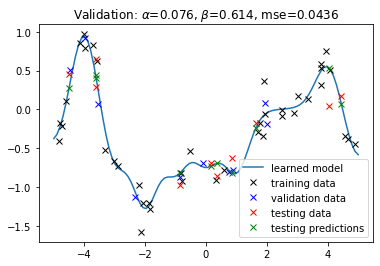

In [3]:
# Template for problem 2
# Specify possible values for the alpha and beta parameters to test
alphas = np.logspace(-3, 3, 100)
betas = np.logspace(-3, 3, 100)

# Grid search over possible values of alpha and beta
mse_valid = np.zeros((len(alphas), len(betas)))
for a, alpha in enumerate(alphas):
    for b, beta in enumerate(betas):
        
        # Use here functions rbf and bayesian_linear_regression to fit the
        # model and compute the prediction error (using mean squared error)
        # for the validation data
        m, S, log_likelihood = bayesian_linear_regression(rbf(x_train,centers,lambdaval), y_train, alpha, beta)
        pred = rbf(x_valid, centers, lambdaval) @ m
        mse_valid[a,b] = ((pred-y_valid)**2).mean()
        
# What are the optimal values of alpha and beta, that minimize the prediction error in the validation data?
min_index = np.where(mse_valid == np.min(mse_valid))

best_alpha = alphas[min_index[0]]
best_beta = betas[min_index[1]]


# Fit the model one more time using the optimal alpha and beta and all data 
# available for model fitting (both training and validation sets)
x_fit = np.concatenate((x_train,x_valid), axis=0)
y_fit = np.concatenate((y_train,y_valid), axis=0)
best_m, best_S, best_log_likelihood =  bayesian_linear_regression(rbf(x_fit,centers,lambdaval), y_fit, best_alpha, best_beta)

x_coord = np.linspace(x_range[0], x_range[1], 100)

# Compute the predicted values for inputs in x_coord using best_m
y_mean = rbf(x_coord,centers, lambdaval)@best_m


# Plot the final learned regression function, together with the samples
plt.plot(x_coord, y_mean, label="learned model")
plt.plot(x_train, y_train, 'kx', label="training data")
plt.plot(x_valid, y_valid, 'bx', label="validation data")
plt.plot(x_test, y_test, 'rx', label="testing data")

# Make predictions for inputs in the test data, so that you get
# predictions 'y_pred' for inputs in x_test.
y_pred = rbf(x_test, centers, lambdaval) @ best_m


# Plot the predictions
plt.plot(x_test, y_pred, 'gx', label="testing predictions")

# Compute the mean squared prediction error for the test data.
mse_test = ((y_pred-y_test)**2).mean() 


plt.legend()
plt.title("Validation: $\\alpha$=%.3f, $\\beta$=%.3f, mse=%.4f" %
          (best_alpha, best_beta, mse_test))
plt.show()

# Problem 3: Poisson regression with Laplace approximation

Poisson regression can be used to model count data. A Poisson regression model can be defined as
\begin{align}
    y_i \mid \boldsymbol{\theta} & \sim \operatorname{Poisson}(\exp(\boldsymbol{\theta}^T \mathbf{x}_i )) \\
    \theta &\sim \mathcal{N}(\mathbf{0}, \alpha^{-1} \mathbf{I})
\end{align}
where $y_i$ are the observed counts, $\mathbf{x}_i$ the related covariates, $i = 1,\ldots,N$, and $\boldsymbol{\theta}^T$ are the regression weights. In this exercise, we approximate the posterior $p(\boldsymbol{\theta} \mid \mathbf{y})$ using the Laplace approximation. We will do this in two steps. In the first step we will derive the gradient $-\nabla \log p(\boldsymbol{\theta} \mid \mathbf{y} )$ and in the second step we will write Laplace approximation. And finally, we will look compare the true density with the laplace approximation.  

**(a)** Derive the gradient $-\nabla \log p(\boldsymbol{\theta} \mid \mathbf{y} )$ and the Hessian $\mathbf{H} = -\nabla\nabla\log p( \boldsymbol{\theta} \mid y)$ needed for the Laplace approximation. 

**(b)** Write the Laplace approximation as the density of a Gaussian distribution. What is the mean and the covariance matrix of this distribution?  

**(c)** Compare the Laplace approximation to the true posterior (computed using numerical integration), in a case where we have one-dimensional covariates only. Use data given in the file 'ex4\_4\_data.txt' and hyperparameter value $\alpha = 10^{-2}$. Plot the two posteriors and the true value $\theta = \pi/4$ used to generate the data. Also plot the data with the regression line $\hat y_i = \exp(\hat\theta x_i)$ using the MAP estimate $\hat{\boldsymbol{\theta}}$. The code template below at the end of the notebook will help with this.


### Solutions to 3a and 3b
Write your solutions to __(3a)__ and __(3b)__ in LateX or attach a picture in this cell.


#### a)
\begin{align}
	p(\theta \mid \mathbf{y}) &= \frac{p(\mathbf{y} \mid \theta) p(\theta)}{p(\mathbf{y})}\\
	&\propto p(\mathbf{y} \mid \theta) p(\theta)\\
	&= \text{Poisson}\left( \exp(\theta^\top \mathbf{X})\right) \mathcal{\mathbf{y}}(\mathbf{0}, \alpha^{-1}\mathbf{I})\\
	& \propto \frac{1}{\mathbf{y!}}\exp(-\exp(\theta^\top \mathbf{X})) (\exp(\theta^\top \mathbf{X}))^\mathbf{y} \exp\left(-\frac{1}{2}(\theta)^\top (\alpha \mathbf{I})(\theta)\right)\\
	\log\left( p(\theta \mid \mathbf{y})\right) &= -\log(\mathbf{y!})-\exp(\theta^\top \mathbf{X}) +\mathbf{y}(\theta^\top \mathbf{X}) -\frac{\alpha}{2}(\theta)^\top (\theta)\\
	-\nabla \log\left( p(\theta \mid \mathbf{y})\right) &= -\mathbf{y}\mathbf{X} + \mathbf{X} \exp(\theta^\top \mathbf{X}) + \alpha\theta \\
	H = -\nabla^2 \log\left( p(\theta \mid \mathbf{y})\right) &= \mathbf{X}\mathbf{X}^\top \exp(\theta^\top \mathbf{X}) + \alpha \mathbf{I}
\end{align}

#### b)
From the lecture slides, we know that the posterior mean estimate is the $\theta$ which minimizes the gradient, we call it $\bar{\theta}$.

Similarly, the covariance is equal to the inverse of the Hessian evauated at $\bar{\theta}$, i.e. $S=\mathbf{H^{-1}_\bar{\theta}}$.

The gaussian density is thus $\mathcal{N}(\theta \mid \bar{\theta}, \mathbf{H^{-1}_\bar{\theta}})$.

Hessian: 277.41


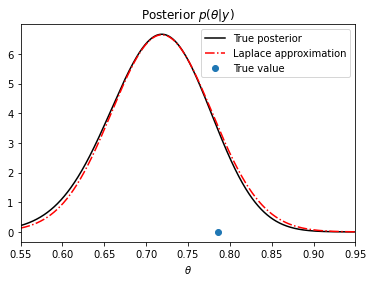

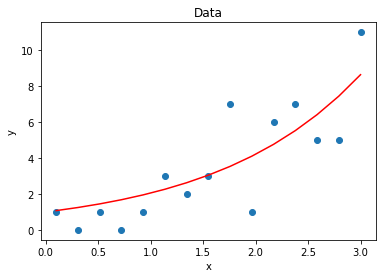

In [9]:
# Template for problem 3(c)
# NOTE: starter code at the begining of the notebook and function 'bayesian_linear_regression' 
#       is required to run this cell

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.stats import norm

# get some data
data = np.loadtxt('/coursedata/ex4_4_data.txt')
x = data[:,0]
y = data[:,1]

theta_true = np.pi / 4 # true parameter used to generate the data
alpha = 1e-2 # prior's parameter

# compute Laplace approximation
theta_lapl = 0.5 # initial
# iterate to optimum with newton's method to find the MAP estimate for theta
for iter in range(100):
    # compute gradient
    grad = -y@x + x @ np.exp(theta_lapl * x) + alpha*theta_lapl
    # compute Hessian
    H = x@(x.T * np.exp(theta_lapl * x) + alpha)
    
    theta_lapl = theta_lapl - grad / H # do newton step

# compute Hessian at optimum
H = x@(x.T * np.exp(theta_lapl * x) + alpha)

# YOUR CODE HERE

print("Hessian: {:.2f}".format(H))
difference = theta_lapl - theta_true

# plot posterior densities
theta = np.linspace(0.55, 0.95, 1000)
post_true = np.zeros(len(theta))
for i in range(len(theta)):
    # log posterior:    
    post_true[i] = (np.dot(y, x * theta[i]) - np.sum(np.exp(x * theta[i]) -
                    np.log(factorial(y))) - 0.5*alpha*np.dot(theta[i], theta[i]))

M = np.amax(post_true)
post_true = np.exp(post_true-M) / np.sum(np.exp(post_true-M)) / (theta[1]-theta[0]) # normalize

# compute approximative density at the points 'theta'
# Hint: you can use norm.pdf from scipy.stats
post_laplace = norm.pdf(theta, loc=theta_lapl, scale=np.sqrt(1/H))
               
    
plt.figure(1)
plt.plot(theta, post_true, '-k', label="True posterior")
plt.plot(theta, post_laplace, '-.r', label="Laplace approximation")
plt.plot(theta_true, 0, 'o', label="True value")
plt.xlim(0.55, 0.95)
plt.xlabel('$\\theta$')
plt.title('Posterior $p(\\theta|y)$')
plt.legend()

plt.figure(2)
plt.plot(x, y, 'o', x, np.exp(theta_lapl*x), '-r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()